In [1]:
from agents.theoritical_agent import *
from agents.angle_agent import *
from agents.observation_agent import *
from agents.control_rnn import *
from agents.pre_rnn import *
from agents.post_rnn import *
from agents.universal_rnn import *
from env import *
import numpy as np
from tf_to_mat import *

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

2024-04-05 11:39:34.511183: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-05 11:39:34.660389: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-05 11:39:34.660429: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-05 11:39:34.687905: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-05 11:39:34.749571: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-05 11:39:34.750269: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
tf.keras.backend.set_floatx('float64')

In [3]:
#Parameters
kappa = 0.5 #Kappa for the von mises
deck_size = 12 #length sequences
optimal_training = False #Training on optimal labels instead of real ones

nb = 1 #Nb of networks to train
batch_size = 2000 #Batch size for the training (length of the training)
rnn_noise = None #Std for noisy networks (put None if you don't want a noisy network)
random_training = True #Training on sequence of random length chosen uniformely in [|1,12|]
separated_params = (10,2) #(Nb of neurons which will see the first part of the input,size of the first part of the input)

free_feedback = True #True = free feedback in the recurrent network / False = only REF -> SEQ feedbacks

activation = 'tanh' #Activation function

separated = False #Separated network

condition = 'pre'

In [4]:
if optimal_training:
    random_training = False #Random training cannot be used with random_training (technical issues)

### Plotting

In [5]:
env = Env(deck_size,kappa=kappa,condition=condition)
agent = UniversalRNN(64,activation=activation,noise=rnn_noise)
agent.postname = condition #Set path name for saving and loading

In [6]:
agent.load('lazy-pre-1.0-a')

LOADING ['nn', 'out_nn']


In [7]:
from sklearn.decomposition import PCA
from analyse.plot_pca import *

In [8]:
pca_batch_size = 2000 #Batch size to fit the PCA on
pca_axes = [0,1,2] #Axes of the pca to plot (3 max)

nb_variance = 10 #Nb of variance to plot

In [9]:
#Pre compute batch
batch_obsf = env.sample_batch(pca_batch_size) 
batch_obs = batch_obsf.get('obs')

In [10]:
#Def residue function
def residue(X,Y):
    from sklearn.linear_model import LinearRegression
    Lg = LinearRegression()
    XX = np.reshape(X,(-1,X.shape[-1]))
    YY = Y
    Lg.fit(YY,XX)
    print("score",Lg.score(YY,XX))
    #assert False
    pred = Lg.predict(YY)
    pred = np.reshape(pred,X.shape)
    return X - pred

In [11]:
out = agent.nn(batch_obs).numpy()[:,:,:]
choice = agent.predict(batch_obsf).numpy()

In [12]:
#fit pca
pca = fit_pca(out.reshape((-1,64)),nb_components=nb_variance)
pca_batch = pca.transform(out.reshape((-1,64))).reshape(out.shape[:-1]+(nb_variance,))

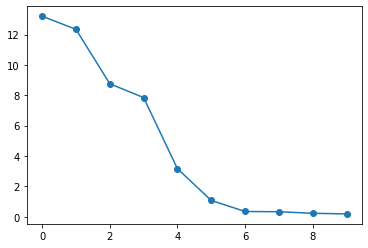

In [13]:
%matplotlib inline
#plot explained variance
plt.plot(range(nb_variance),pca.explained_variance_,marker='o')
plt.show()

In [14]:
#Plot background function
def plot_bg(pca_batch,zorder=0):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlabel('pca1')
    ax.set_ylabel('pca2')
    ax.set_zlabel('pca3')
    colors = [(i/deck_size,(1-i/deck_size),(i-6)**2/36) for i in range(pca_batch.shape[1])]
    cm = plt.get_cmap('rainbow')
    obj = batch_obsf.get('mean')[:,0]/(2*np.pi)
    obj = batch_obsf.get('ref')/(2*np.pi)
    mean_angle = np.mean(batch_obsf.get('obs')[:,:,:2],axis=1)
    #obj = (np.arctan2(mean_angle[:,1],mean_angle[:,0])+np.pi)/(2*np.pi)
    #obj = batch_obsf.get('color')/0.5
    #obj = choice/0.5
    colors = [[cm(ref) for ref in obj] for i in range(pca_batch.shape[1])]
    unique_refs = np.unique(obj)
    for i,r in enumerate(unique_refs):
        c = cm(r)
        label = str(r)
        ax.plot([0],[0],[0],color=c,label=label,zorder=zorder)
    for i in range(pca_batch.shape[1]):
        ax.scatter(pca_batch[:,i,0],pca_batch[:,i,1],pca_batch[:,i,2],color=colors[i],alpha=0.1,marker='.',zorder=zorder)

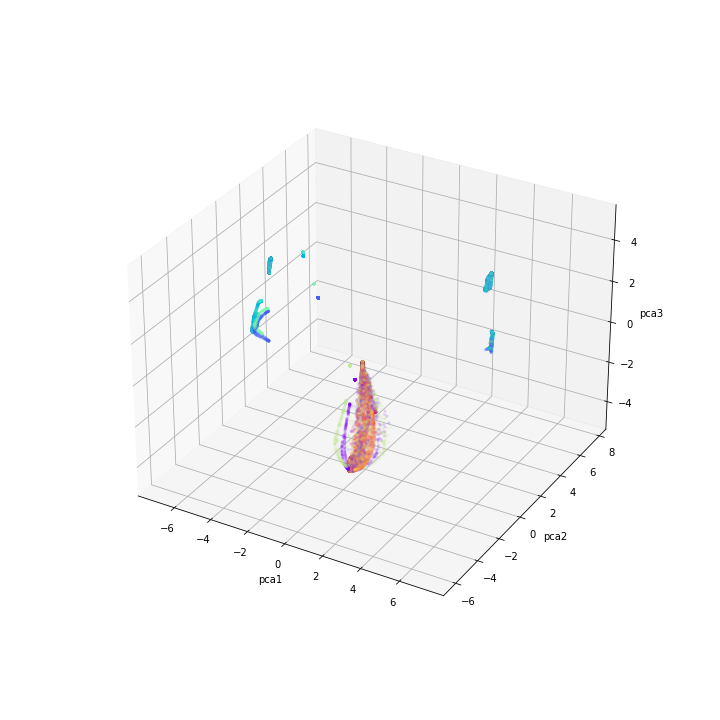

In [15]:
%matplotlib widget
from mpl_toolkits import mplot3d
plot_bg(pca_batch)
plt.show()

### Plot performance curves

In [41]:
d = {}
for style in ['universal','lazy']:
    for noise in range(0,11):
        for iteration in ["a","b","c","d","e","f","g","h","i","j","k","l","m","n","o"]:
        #open numpy file
            try:
                data = np.load('models/'+style+'-pre-'+str(noise/10)+'-'+iteration+'/scores.npy')
            except FileNotFoundError:
                print('not found',style,noise)
                data = None
            #set the data to the keys [style][noise][iteration] in d
            if style not in d:
                d[style] = {}
            if noise/10 not in d[style]:
                d[style][noise/10] = {}
            d[style][noise/10][iteration] = data

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


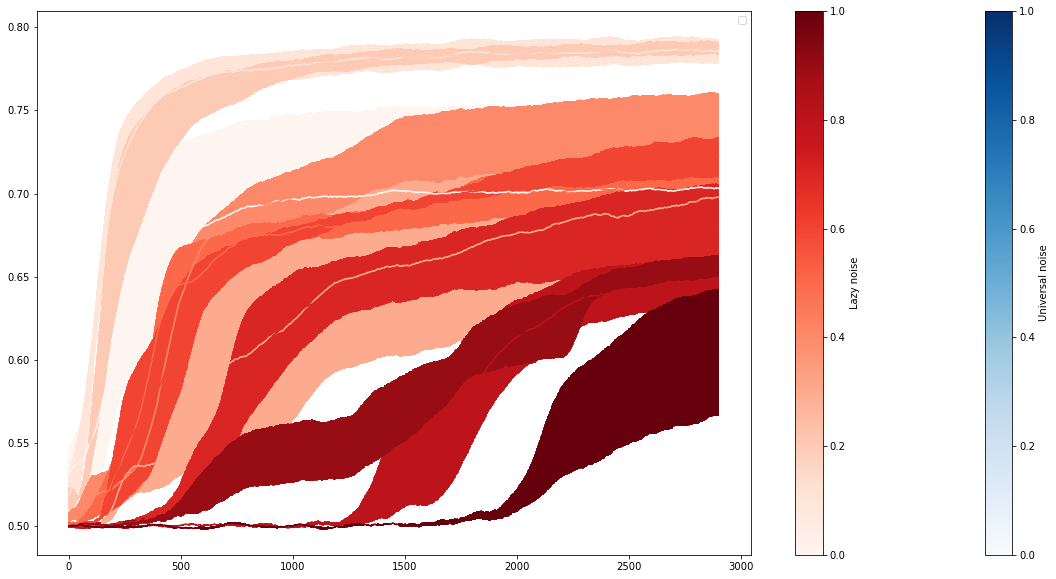

In [56]:
%matplotlib inline
import matplotlib.cm as cm

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)

# Get the color maps for blue and red gradients
blue_cmap = cm.get_cmap('Blues')
red_cmap = cm.get_cmap('Reds')

for style in d:
    for noise in d[style]:
        data = []
        for iteration in d[style][noise]:
            if d[style][noise] is not None:
                curve = d[style][noise][iteration]
                smoothed_curve = np.convolve(curve, np.ones(100)/100, mode='valid')
                data.append(smoothed_curve)
        # Calculate the color based on the noise value
        color = blue_cmap(noise) if style == 'universal' else red_cmap(noise)
        
        # Plot the data with the corresponding color
        if style == 'lazy':
            ax.errorbar(range(len(data[0])),np.mean(data,axis=0),yerr=np.std(data,axis=0)/np.sqrt(len(data)),color=color)

#Put a blue colorbar and a red one for the noise and name the colorbars as the style
blue_sm = plt.cm.ScalarMappable(cmap=blue_cmap)
blue_sm.set_array([])
blue_cbar = plt.colorbar(blue_sm, ax=ax)
blue_cbar.set_label('Universal noise')

red_sm = plt.cm.ScalarMappable(cmap=red_cmap)
red_sm.set_array([])
red_cbar = plt.colorbar(red_sm, ax=ax)
red_cbar.set_label('Lazy noise')

plt.legend()